<Figure size 1000x900 with 0 Axes>

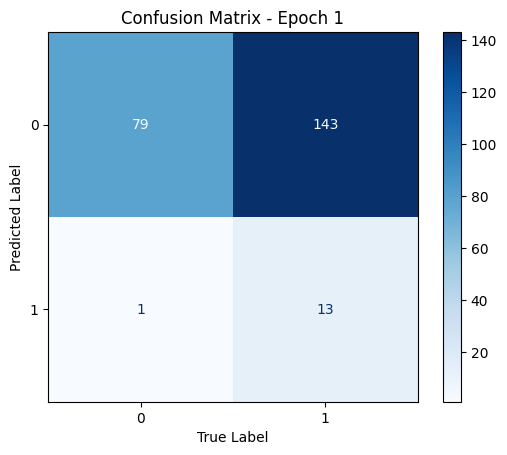

Epoch [1/50], Loss: 0.4877808471520742, Attention Loss: 0.14563459157943726
Test Accuracy: 0.3898305084745763


<Figure size 1000x900 with 0 Axes>

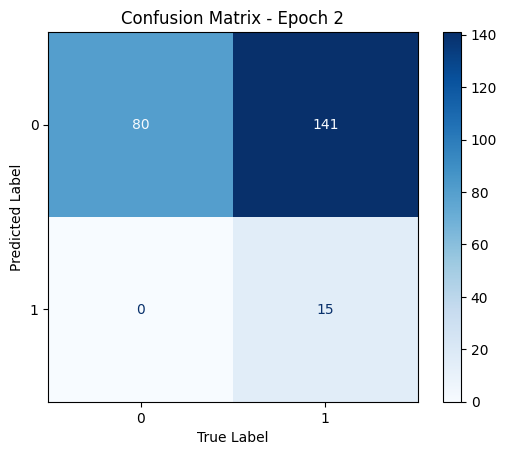

Epoch [2/50], Loss: 0.2582189326484998, Attention Loss: 0.10963582247495651
Test Accuracy: 0.4025423728813559


<Figure size 1000x900 with 0 Axes>

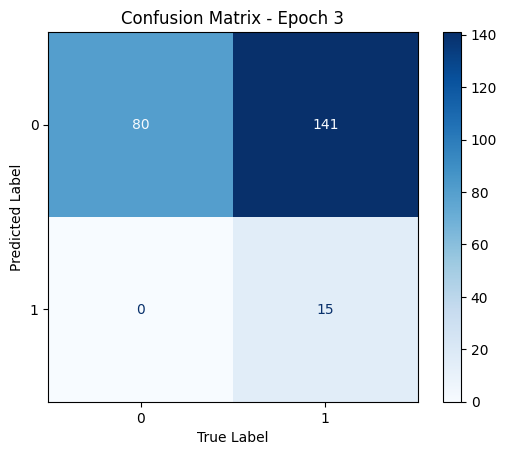

Epoch [3/50], Loss: 0.20204923897981644, Attention Loss: 0.12198859453201294
Test Accuracy: 0.4025423728813559


<Figure size 1000x900 with 0 Axes>

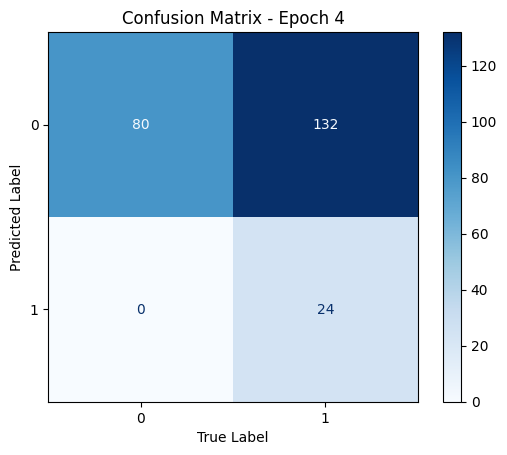

Epoch [4/50], Loss: 0.15102546016375223, Attention Loss: 0.08852867782115936
Test Accuracy: 0.4406779661016949


<Figure size 1000x900 with 0 Axes>

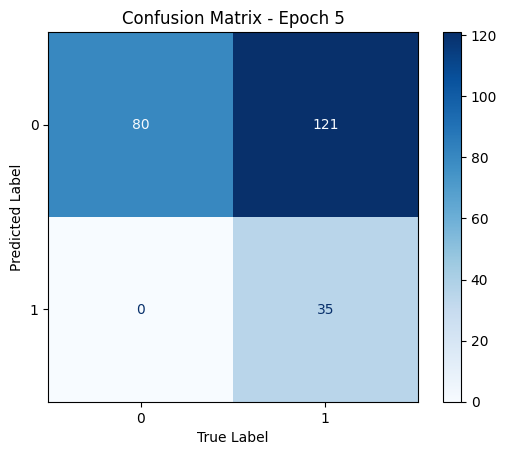

Epoch [5/50], Loss: 0.09022395461797714, Attention Loss: 0.0959324836730957
Test Accuracy: 0.4872881355932203


<Figure size 1000x900 with 0 Axes>

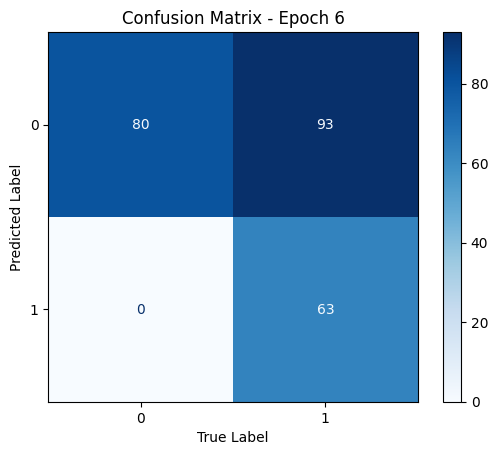

Epoch [6/50], Loss: 0.07392437215894461, Attention Loss: 0.10572023689746857
Test Accuracy: 0.6059322033898306


<Figure size 1000x900 with 0 Axes>

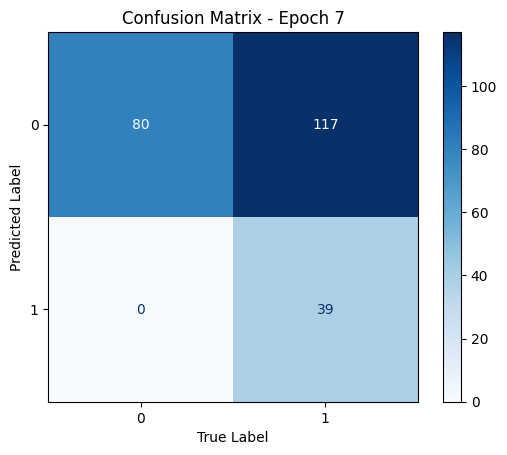

Epoch [7/50], Loss: 0.05046076017121474, Attention Loss: 0.0658874362707138
Test Accuracy: 0.5042372881355932


<Figure size 1000x900 with 0 Axes>

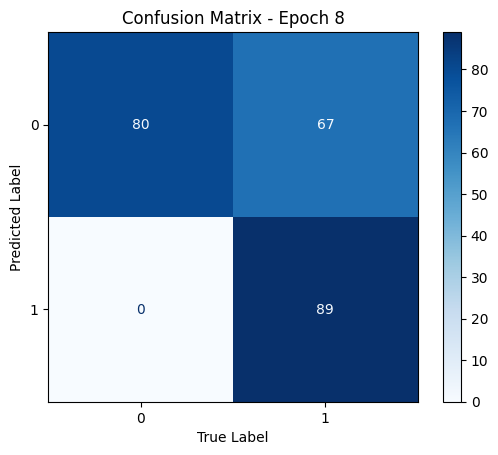

Epoch [8/50], Loss: 0.04052397242436807, Attention Loss: 0.06954669207334518
Test Accuracy: 0.7161016949152542


Exception ignored in: <function _ConnectionBase.__del__ at 0x7f47bc5c0790>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 132, in __del__
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


<Figure size 1000x900 with 0 Axes>

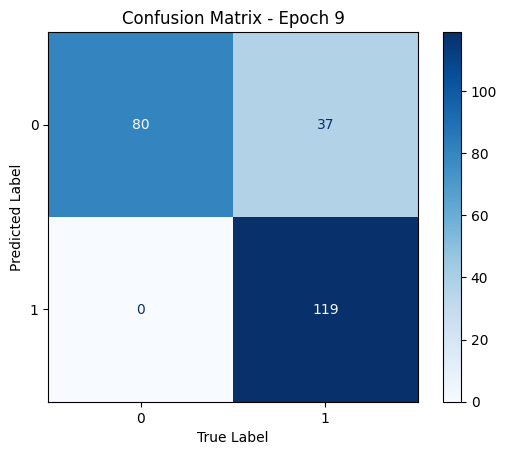

Epoch [9/50], Loss: 0.029692389195164044, Attention Loss: 0.06543673574924469
Test Accuracy: 0.8432203389830508


<Figure size 1000x900 with 0 Axes>

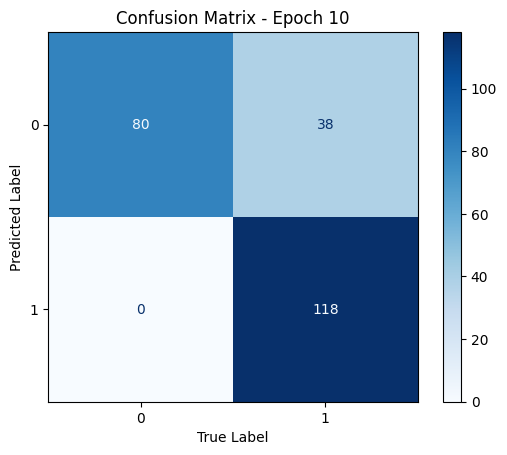

Epoch [10/50], Loss: 0.0243363699875772, Attention Loss: 0.06751880794763565
Test Accuracy: 0.8389830508474576


<Figure size 1000x900 with 0 Axes>

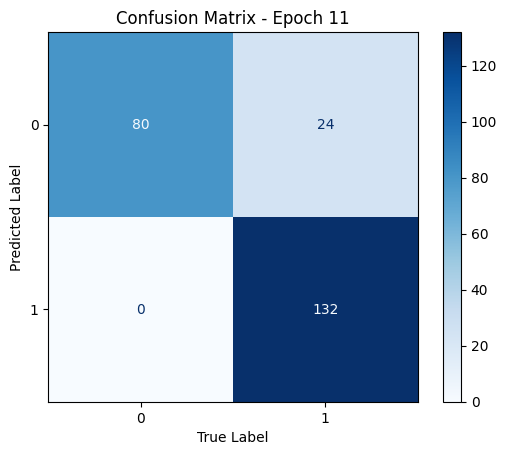

Epoch [11/50], Loss: 0.009947626874782145, Attention Loss: 0.06156453862786293
Test Accuracy: 0.8983050847457628


<Figure size 1000x900 with 0 Axes>

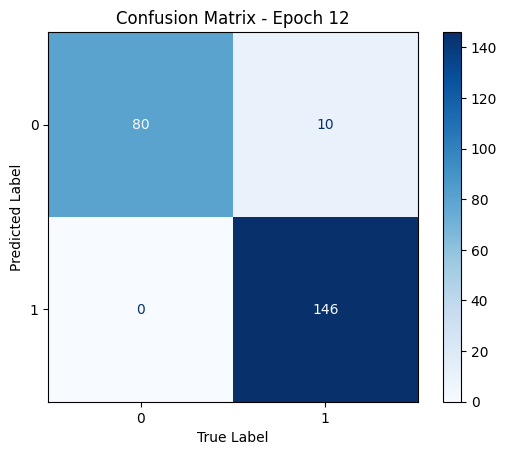

Epoch [12/50], Loss: 0.015975335791396598, Attention Loss: 0.07565707713365555
Test Accuracy: 0.9576271186440678


<Figure size 1000x900 with 0 Axes>

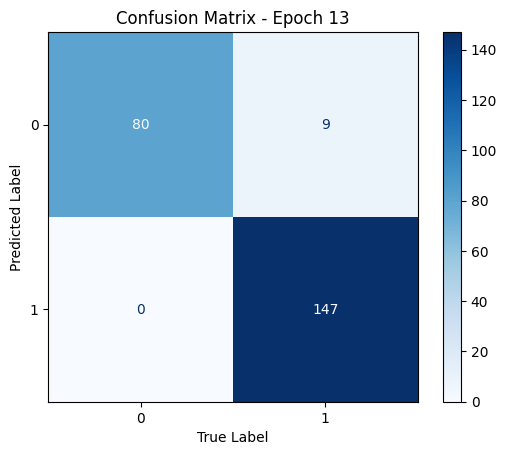

Epoch [13/50], Loss: 0.027828984210888544, Attention Loss: 0.06196106970310211
Test Accuracy: 0.961864406779661


<Figure size 1000x900 with 0 Axes>

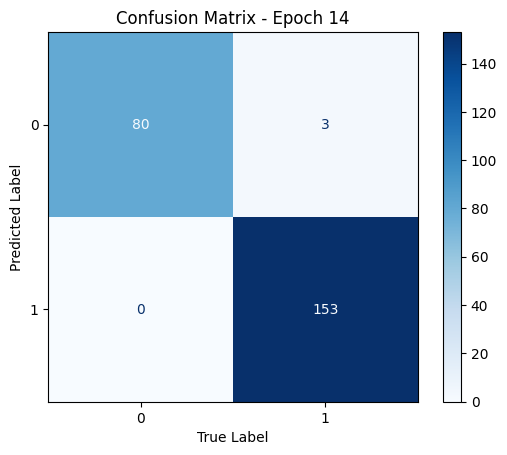

Epoch [14/50], Loss: 0.012691940708706776, Attention Loss: 0.051851242780685425
Test Accuracy: 0.9872881355932204


<Figure size 1000x900 with 0 Axes>

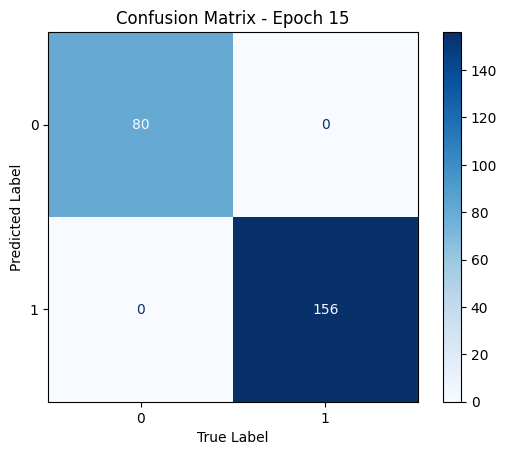

Epoch [15/50], Loss: 0.010492956746990483, Attention Loss: 0.04904278740286827
Test Accuracy: 1.0


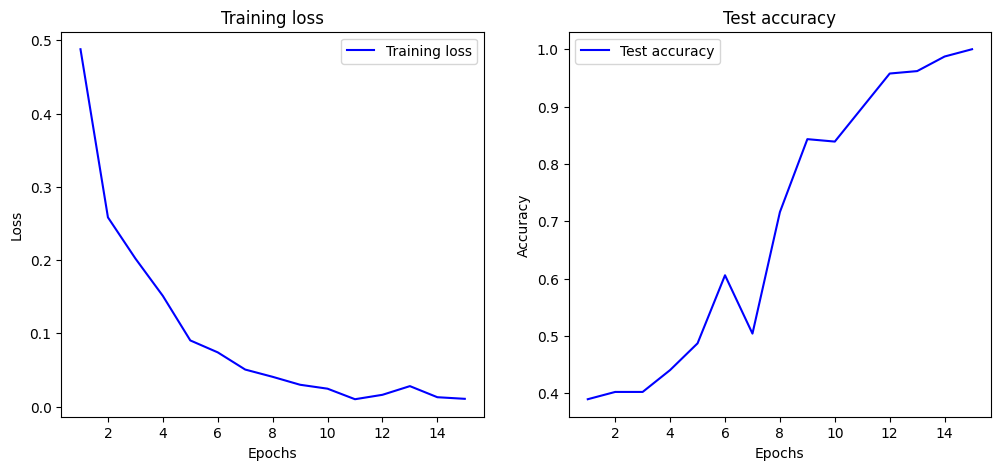

<Figure size 1000x900 with 0 Axes>

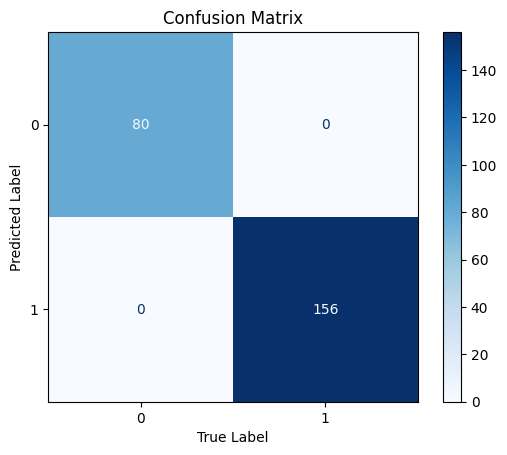

Class 0 accuracy: 1.0000
Class 1 accuracy: 1.0000


In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import os
from PIL import Image
import datetime
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import xml.etree.ElementTree as ET
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import ImageFilter
# Load the pre-trained VGG16 model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
class vgg16_base(nn.Module):
    def __init__(self):
        super(vgg16_base, self).__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
        self.features = vgg.features
        self.avgpool = vgg.avgpool
        set_parameter_requires_grad(self.features, True)
        self.classifier=nn.Sequential(
            nn.Linear(512*7*7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 6)
        )
    def forward(self, x):
        x = self.features(x) 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
class mobilenetv3_(nn.Module):
    def __init__(self, num_classes=2):
        super(mobilenetv3_, self).__init__()
        # MobileNetV3 特征提取
        mobile = models.mobilenet_v3_large(weights=models.MobileNet_V3_Large_Weights.IMAGENET1K_V2)
        self.features = mobile.features
        self.avgpool = mobile.avgpool
        set_parameter_requires_grad(self.features, False)
        self.num_classes = num_classes
        # 分类器
        self.classifier = nn.Sequential(
            nn.Linear(960, 1280),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1280, 1280),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(1280, num_classes)
        )
        self.feature_maps = None
        self.gradients = None

        self.features[-1].register_forward_hook(self.save_feature_maps)
        self.features[-1].register_full_backward_hook(self.save_gradients)
    
    def save_feature_maps(self, module, input, output):
        self.feature_maps = output
    
    def save_gradients(self, module, input, grad_output):
        self.gradients = grad_output[0]

    def forward(self, x, mask=None, annotation=None):
        features = self.features(x)
        x = self.avgpool(features)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        attention_loss = 0.0
        if mask is not None and torch.sum(mask) > 0:
            with torch.enable_grad():
                # 创建独热向量
                # Initialize attention loss
                attention_loss = 0.0
                one_hot = torch.zeros_like(x)
                one_hot.scatter_(1, annotation.view(-1, 1), 1.0)
                
                # Backpropagate to get gradients
                gradients = torch.autograd.grad(outputs=x, inputs=features, grad_outputs=one_hot, retain_graph=True, create_graph=True)[0]
                # Calculate heatmap
                pooled_gradients = torch.mean(gradients, dim=[2, 3], keepdim=True)
                heatmap = features * pooled_gradients
                heatmap = torch.sum(heatmap, dim=1, keepdim=True)
                heatmap = torch.relu(heatmap)
                
                # Normalize heatmap to 0-1 range
                B, C, H, W = heatmap.size()
                heatmap_flat = heatmap.view(B, C, -1)
                heatmap_max, _ = torch.max(heatmap_flat, dim=2, keepdim=True)
                heatmap_min, _ = torch.min(heatmap_flat, dim=2, keepdim=True)
                heatmap_max = heatmap_max.unsqueeze(-1)
                heatmap_min = heatmap_min.unsqueeze(-1)
                
                # Avoid division by zero
                epsilon = 1e-7
                normalized_heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min + epsilon)
                
                # Resize mask to match heatmap size
                # if annotation==i:
                mask_resized = F.interpolate(mask, size=(H, W), mode='bilinear', align_corners=False)
                # else:
                #     mask_resized = torch.zeros_like(normalized_heatmap)
                # Calculate heatmap loss (MSE loss)
                attention_loss = F.mse_loss(normalized_heatmap, mask_resized)
        return x, attention_loss
class tablet_dataset(Dataset):
    def __init__(self, image_dir, annotation_dir, image_transform=None):
        super().__init__()
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_filenames = [f for f in os.listdir(image_dir) if f.endswith('.bmp') and not f.endswith('_t.bmp')]
        self.image_transform = image_transform
    def __len__(self):
        return len(self.image_filenames)
    def __getitem__(self, idx):
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        annotation = 0
        mask_name = os.path.splitext(img_name)[0] + '_t.bmp'
        mask_path = os.path.join(self.annotation_dir, mask_name)
        xml_filename = os.path.splitext(img_name)[0] + '.xml'
        xml_path = os.path.join(self.annotation_dir, xml_filename)
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root = tree.getroot()
            annotation = int(root.find(".//flags").text)
            if annotation==6:
                annotation=1
            elif annotation==7:
                annotation=6
            elif annotation==8:
                annotation=4
            if annotation>1:
                annotation=1
        mask = None
        if os.path.exists(mask_path) and annotation!=0:
            mask = Image.open(mask_path).convert('L')
            mask = mask.resize((160, 160))
            # Apply dilation to the mask
            mask = mask.filter(ImageFilter.MaxFilter(3))  # 3x3 kernel for dilation
            mask = transforms.ToTensor()(mask)
        else:
            mask = torch.zeros((1, 160, 160))
        if self.image_transform:
            image = self.image_transform(image)
        return image, annotation, mask
# Define the image transformations
image_transform = transforms.Compose([
    transforms.Resize((160,160)),
    # transforms.ColorJitter(contrast=2.0),  # Increase contrast
    transforms.ToTensor(),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
# Modify the VGG16 model for binary classification
mobilenetv3 = mobilenetv3_().to('cuda')
# Apply Xavier initialization to the classifier layers
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

mobilenetv3.classifier.apply(initialize_weights)
# vgg16.load_state_dict(torch.load('vgg16_mask_very_good.pth'))
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenetv3.parameters(), lr=0.0001)

# Initialize lists to store loss and accuracy
train_losses = []
test_accuracies = []

# Function to plot loss and accuracy
def plot_metrics(train_losses, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.title('Training loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot test accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, test_accuracies, 'b', label='Test accuracy')
    plt.title('Test accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()
# Training loop
if __name__ == '__main__':
    # Create the dataset and dataloader
    dataset = tablet_dataset(image_dir='20241108 with rgb', annotation_dir='20241108 with rgb', image_transform=image_transform)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True,num_workers=8)
    testdataset = tablet_dataset(image_dir='train', annotation_dir='train', image_transform=image_transform)
    testloader = DataLoader(testdataset, batch_size=32, shuffle=True,num_workers=8)
    num_epochs = 50
    for epoch in range(num_epochs):
        mobilenetv3.train()
        running_loss = 0.0
        if epoch==20:
            optimizer = optim.Adam(mobilenetv3.parameters(), lr=0.00001)
        for images, labels, masks in dataloader:
            
            images = images.to('cuda')
            labels = labels.to('cuda')
            masks = masks.to('cuda')
            optimizer.zero_grad()
            # if masks is not None:
            outputs, attention_loss = mobilenetv3(images, masks, labels)
            loss = criterion(outputs, labels) + 1 * attention_loss
            loss.backward()
            optimizer.step()
            
            running_loss += criterion(outputs, labels).item()
        train_losses.append(running_loss/len(dataloader))
        mobilenetv3.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels, _ in testloader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                outputs, _ = mobilenetv3(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        accuracy = correct / total
        test_accuracies.append(accuracy)
        # Generate confusion matrix for each epoch
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for images, labels, _ in testloader:
                images = images.to('cuda')
                labels = labels.to('cuda')
                
                outputs, _ = mobilenetv3(images)
                _, predictions = torch.max(outputs, 1)
                
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        # Convert lists to numpy arrays
        all_predictions = np.array(all_predictions)
        all_labels = np.array(all_labels)

        # Generate confusion matrix
        cm = confusion_matrix(all_labels, all_predictions).T
        num_classes = len(np.unique(np.concatenate([all_labels, all_predictions])))

        # Display the confusion matrix
        plt.figure(figsize=(10, 9))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                    display_labels=list(range(num_classes)))
        disp.plot(cmap=plt.cm.Blues)
        plt.xlabel('True Label')
        plt.ylabel('Predicted Label')
        plt.title(f'Confusion Matrix - Epoch {epoch+1}')
        plt.show()
        plt.close()  # Close the figure to prevent memory issues
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}, Attention Loss: {attention_loss.item()}')
        print(f'Test Accuracy: {accuracy}')
        if accuracy>.92:
            optimizer = optim.Adam(mobilenetv3.parameters(), lr=0.00001)
        if accuracy==1:
            break
        # Track and save the best model based on accuracy
        if not hasattr(mobilenetv3, 'best_accuracy') or accuracy > mobilenetv3.best_accuracy:
            mobilenetv3.best_accuracy = accuracy
            timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
            global best_model_path
            # best_model_path = f'mobilenetv3_best_model_{accuracy:.4f}_{timestamp}.pth'
            # torch.save(mobilenetv3.state_dict(), best_model_path)
            # print(f'Saved new best model with accuracy: {accuracy:.4f}')
    timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    # torch.save(vgg16.state_dict(), f'vgg16_model_{num_epochs}epoch_{timestamp}.pth')
    plot_metrics(train_losses, test_accuracies)
    # Add code for confusion matrix evaluation
    # vgg16.load_state_dict(torch.load(best_model_path))
    # Set model to evaluation mode
    mobilenetv3.eval()

    # Initialize lists to store predictions and true labels
    all_predictions = []
    all_labels = []

    # Collect predictions and labels from the test set
    with torch.no_grad():
        for images, labels, _ in testloader:
            images = images.to('cuda')
            labels = labels.to('cuda')
            
            outputs, _ = mobilenetv3(images)
            _, predictions = torch.max(outputs, 1)
            
            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Convert lists to numpy arrays
    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)

    # Generate confusion matrix with axes swapped (predictions on y-axis, true labels on x-axis)
    cm = confusion_matrix(all_labels, all_predictions).T
    num_classes = len(np.unique(np.concatenate([all_labels, all_predictions])))

    # Display the confusion matrix
    plt.figure(figsize=(10, 9))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                 display_labels=list(range(num_classes)))
    disp.plot(cmap=plt.cm.Blues)
    plt.xlabel('True Label')
    plt.ylabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix_mask4.png')
    plt.show()
    # Calculate per-class accuracy (adjusted for transposed matrix)
    per_class_accuracy = cm.sum(axis=0) / cm.sum(axis=1)
    for i, accuracy in enumerate(per_class_accuracy):
        print(f'Class {i} accuracy: {accuracy:.4f}')
    # Save the model
    torch.save(mobilenetv3.state_dict(), 'mobilenetv3_bin_model.pth')